# Tweet Sentiment Analysis

## Import Statements

In [1]:
from fastai2.text.all import *
# import plotly.express as px

In [2]:
df = pd.read_csv('tweets_500thou.csv')

In [3]:
df.columns

Index(['target', 'id', 'date', 'flag', 'user', 'text'], dtype='object')

## Utilizing out of the box language model from `fastai`

The standard `fastai` language model was build from all the non-trivial Wikipedia articles.

In [6]:
dls = TextDataLoaders.from_df(df, text_col='text', label_col='target', 
                              shuffle_train=False, bs=128)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
dls.show_batch()

,text,category
0,xxbos xxunk à ® xxunk ® xxunk ® ¤à ® ¿à ® ° à ® xxunk ® ªà ® xxunk ® xxunk ® xxunk à ® ªà ® xxunk ® ¤à ® xxunk ! à ® xxunk ® xxunk ® ¤à ® ¿à ® ° à ® à¯?à ® à ® xxunk ® ° à ® © xxunk ® à¯?à ® xxunk ? à ® à ® xxunk ® ¿à ® xxunk ? à ® ® à ® à¯?à ® xxunk ? xxunk,4
1,xxbos xxunk xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxup do xxup it xxpad xxpad,4
2,xxbos # xxup bts is fallin ! ! # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts # xxup bts xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
3,xxbos xxunk ? ° xxunk ° xxunk xxunk xxunk ▁ xxunk xxunk ° ì ¦ xxunk xxunk ▁ xxunk xxunk ? ´ xxunk xxunk ° xxunk xxunk … xxunk ì ¿ xxunk ▁ ì ° xxunk xxunk ? ´ xxunk xxunk xxunk ° xxunk ▁ xxunk xxunk xxunk xxunk ° xxunk xxunk  ì ° xxunk ? ´ xxunk xxunk xxunk ▁ xxunk ▁ xxunk ° xxunk … xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
4,xxbos xxup oh xxup em xxup f'ing g xxrep 4 e i xxup never xxup kne xxrep 3 w ! xxup never xxup would xxup have xxup thought xxup eve xxrep 4 r xxup in xxup my xxup lif xxrep 3 e ! xxup this xxup is s xxrep 4 o xxup crazy i xxup wa xxrep 3 n a xxup fxckin xxup cry xxup lol xxup jk xxup but xxup wow xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0
5,xxbos ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? take that xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4
6,"xxbos xxrep 4 ? , xxrep 6 ? xxrep 9 ? tweetie ? ? xxrep 10 ? xxrep 5 ? direct ' ? ( xxrep 3 ? xxrep 10 ? ) , xxrep 4 ? xxrep 3 ? ? ? xxrep 7 ? ? xxrep 4 ? xxrep 6 ? xxrep 3 ? xxrep 3 ? ? xxrep 4 ? xxrep 3 ? - xxrep 3 ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0
7,"xxbos xxmaj who xxmaj am i xxmaj lying ! ? ! i xxmaj know , xxmaj you xxmaj know , xxmaj we xxmaj all xxmaj know , xxmaj my xxmaj ass xxmaj is xxmaj still xxmaj gon na xxmaj be xxmaj up . xxmaj hehe . xxmaj my xxmaj ass xxmaj ca n't xxmaj sleep . i xxmaj need xxmaj help . xxmaj for xxmaj real ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0
8,xxbos @songzy xxrep 3 u p o xxup my ! u r xxup over 100k & ' xxunk & ' ( i m xxup one xxup of xxup them xxup so xxup i 'm j / xxup k ! ) i xxup lost xxup dis xxup bet xxup dat xxup i 'd xxup get a xxup reply 4rm u xxup b4 u xxup got xxup there ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0


In [8]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=9.12010818865383e-07)

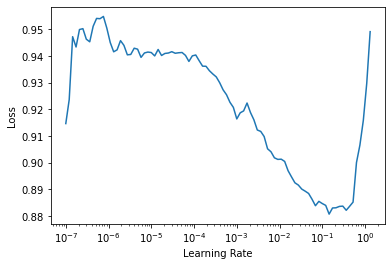

In [9]:
learn.lr_find()

In [10]:
learn.fine_tune(3, 4.4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.752270,0.596586,0.671530,02:09


epoch,train_loss,valid_loss,accuracy,time
0,0.380937,0.448160,0.804030,04:54
1,0.340983,1.335268,0.805860,04:54
2,0.327785,1.578040,0.820950,04:55


In [11]:
learn.save('3epoch_fine_tune_AWD_LSTM')

In [12]:
learn.show_results()

,text,category,category_
0,xxbos xxunk xxmaj taylor xxunk -- > # & & $ ( # & & $ ! ( @ # $ ( ! @ # * $ ( # ! ( sweet mother of # xxunk # ( $ * ( ! @ # * $ ( ! @ # & & $ ( ! @ # $ & & ! ( @ # ! # xxunk … my xxunk is only xxunk,0,0
1,"xxbos xxrep 5 ? ? ? xxrep 3 ? xxrep 8 ? , xxrep 5 ? ? ? xxrep 3 ? xxrep 7 ? , xxrep 3 ? xxrep 3 ? ? ? xxrep 6 ? xxrep 3 ? ? ? , xxrep 4 ? xxrep 3 ? ? ? xxrep 7 ? … xxmaj the magic of xxmaj xxunk singing for xxmaj xxunk xxmaj xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
2,"xxbos xxmaj mike xxmaj francis ââ xxunk ° xxunk ð½ð ° xxunk ▁ ð xxunk ° xxunk ° ñ ▁ ñ xxmaj blank & & xxmaj jones ( some xxmaj one xxmaj like xxmaj you , i xxmaj love xxmaj you … ) . xxunk ð² ð xxunk xxunk ð¾ñ ñð ° ðºð ° xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,4
3,xxbos xxunk ì xxunk °  xxunk ´ xxunk ° xxunk xxunk ? ^^ ; xxunk xxunk xxunk xxunk ° xxunk xxunk ° xxunk xxunk °  xxunk ? xxunk xxunk xxmaj xxunk xxunk xxunk °  xxunk ° xxunk xxunk xxunk ? xxunk ? ì ? ´ xxunk xxunk xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,4
4,"xxbos xxmaj bout 2 head bk out wit my lil homies . xxmaj its xxmaj lady & & xxmaj lil xxmaj ladies xxmaj day xxmaj out . xxmaj if knw a xxup lil xxup one that needs love tk em out , talk to em , xxmaj show em love xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
5,"xxbos xxmaj greetings xxmaj twiggas . . .finally xxmaj got a xxmaj twitter ! xxmaj left xxmaj peterson , i miss it xxmaj there so xxmaj much . xxmaj thinking xxmaj about xxup xxunk . & & + xxmaj my xxmaj besties i ca n't xxmaj be xxmaj with xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,0
6,xxbos xxmaj hav xxmaj my xxmaj piano xxmaj exam xxmaj in xxmaj an xxmaj hour ! xxmaj i m xxmaj gon na xxmaj cry xxmaj coz xxmaj i m xxmaj gon na xxmaj fail ! xxmaj dnt xxmaj no xxmaj any xxmaj scales ! xxmaj grade 4 xxmaj shit xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
7,"xxbos xxmaj just got back from seein & ' drag xxmaj me xxmaj to xxmaj hell > & ' xxmaj it was pretty cool , love xxmaj xxunk xxmaj raimi . had an xxmaj army of xxmaj darkness feel to it . xxmaj seen preview for xxup hbp xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
8,xxbos xxup holy xxup crap i xxup just xxup read xxup david xxup carradine xxup died xxup in a xxup thai xxup hotel xxup he xxup hanged xxup himself xxup naked xxup from xxup the xxup closet xxup ouch ! xxup r.i.p xxup bill xxup is xxup dead xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0


## Fine tuning & using custom language model

### Custom language model

In [6]:
dls_lm = TextDataLoaders.from_df(df, is_lm=True, text_col='text', valid_pct=0.2, bs=128, seed=101)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [7]:
dls_lm.show_batch(max_n=3)

,text,text_
0,"xxbos @ruby_gem yeah , why not ? xxmaj glad ur feeling good ! it 's good to feel good ! xxbos xxunk oh gas pains from being pregnant … xxbos @bellacullenrpg xxmaj hey xxmaj bella . xxmaj i 'm still trying to find an xxmaj emmett i just put up an ad on twifans xxup lol xxbos i have n't got any food in and have a new credit card being sent","@ruby_gem yeah , why not ? xxmaj glad ur feeling good ! it 's good to feel good ! xxbos xxunk oh gas pains from being pregnant … xxbos @bellacullenrpg xxmaj hey xxmaj bella . xxmaj i 'm still trying to find an xxmaj emmett i just put up an ad on twifans xxup lol xxbos i have n't got any food in and have a new credit card being sent to"
1,"crossing the street by starbux here on 5th st … it came soo close . xxbos i miss xxmaj dallas already xxbos xxmaj looks like xxunk does n't like posts with xxunk / form - data xxbos xxmaj my sister has xxup h1n1 - she does n't look good all pitiful and sick xxbos 8 miles in xxunk , fun run but did n't finish strong - screwed up dist at the","the street by starbux here on 5th st … it came soo close . xxbos i miss xxmaj dallas already xxbos xxmaj looks like xxunk does n't like posts with xxunk / form - data xxbos xxmaj my sister has xxup h1n1 - she does n't look good all pitiful and sick xxbos 8 miles in xxunk , fun run but did n't finish strong - screwed up dist at the end"
2,"… xxmaj jsem xxunk , xxunk m ? & ' kristy , xxmaj are xxmaj you xxmaj doing xxmaj okay ? & ' xxunk o xxunk xxbos i do n't want to drive to xxmaj moody tonight … xxbos whew … glad twitter 's still alive after maintenance xxbos interview went well .. i have the job , its always guaranteed .. but i have to start later xxbos loving my stolen","xxmaj jsem xxunk , xxunk m ? & ' kristy , xxmaj are xxmaj you xxmaj doing xxmaj okay ? & ' xxunk o xxunk xxbos i do n't want to drive to xxmaj moody tonight … xxbos whew … glad twitter 's still alive after maintenance xxbos interview went well .. i have the job , its always guaranteed .. but i have to start later xxbos loving my stolen jackets"


In [8]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.5)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.033113110810518265)

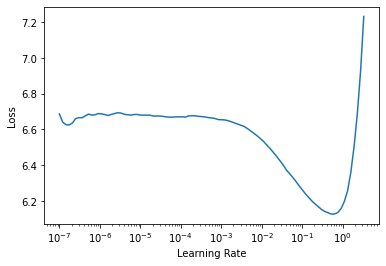

In [9]:
learn.lr_find()

#### 3 epoch Fit One Cycle

In [10]:
learn.fit_one_cycle(3, 5.2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.785416,4.574839,0.223961,97.012428,12:12
1,4.599601,4.421119,0.236676,83.189301,12:13
2,4.395442,4.338806,0.244599,76.615982,12:13


In [11]:
learn.save('3epoch_fit_one_cycle')

In [12]:
learn.fit_one_cycle(1, 5.2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.483485,4.367604,0.242748,78.854492,12:13


In [13]:
learn = learn.load('3epoch_fit_one_cycle')

#### 6 epoch Fit One Cycle

In [27]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], drop_mult=0.5)
learn.fit_one_cycle(6, 6.3e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.913908,4.432177,0.226114,84.114296,01:40
1,4.619577,4.397346,0.226380,81.234947,01:40
2,4.433048,4.354645,0.234543,77.839172,01:40
3,4.276428,4.312634,0.239191,74.636787,01:40
4,4.129568,4.287622,0.241749,72.793190,01:40
5,4.035867,4.282863,0.243498,72.447533,01:40


In [29]:
learn.save('6epoch_fit_one_cycle')

In [30]:
learn = learn.load('6epoch_fit_one_cycle')

#### Fine-tuned with 2-epoch Fit One Cycle

In [14]:
learn = learn.load('3epoch_fit_one_cycle')

In [15]:
learn.unfreeze()
learn.fit_one_cycle(2, 6.3e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.154526,4.147553,0.267788,63.278996,13:07
1,3.971590,4.079482,0.277395,59.114815,13:08


In [16]:
learn.save('finetuned_2epoch')

In [17]:
learn.save_encoder('finetuned_2epoch_encoder')

It looks like we start to overfit at 3 epochs so let's load the saved encoder from above

## Testing Language model

In [18]:
TEXT = "WALKING HOME"
N_WORDS = 13
N_SENTENCES = 3
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [19]:
print("\n".join(preds))

WALKING HOME IN AN EVENING ! too bad the web
WALKING HOME ! SO BORED !!! WORK !
WALKING HOME FROM WORK ! MORE ! LATER NOW !


## Train the text classifier (custom language model)

In [7]:
dls_clas = TextDataLoaders.from_df(df, text_col='text', label_col='target', text_vocab=dls_lm.vocab, seed=102)

/opt/conda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [8]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [29]:
learn = learn.load_encoder('finetuned_2epoch_encoder')

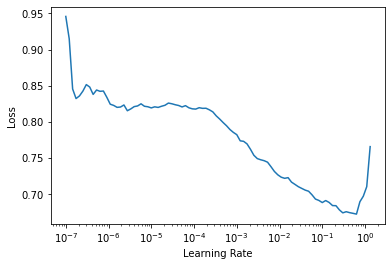

In [24]:
lrs = learn.lr_find()

In [25]:
lrs

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=9.12010818865383e-07)

In [26]:
lr = lrs[0]  #lr_min

In [30]:
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.560335,0.469022,0.789940,02:46
1,0.548026,0.458282,0.786390,02:45
2,0.528113,0.429219,0.799600,02:47
3,0.512595,0.421247,0.804790,02:46


In [31]:
learn.save('4epoch_model_class_model')

In [ ]:
learn = learn.load('4epoch_model_class_model')

In [32]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/500,lr/10))

epoch,train_loss,valid_loss,accuracy,time
0,0.415267,0.374304,0.832880,03:08


In [33]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(lr/5000,lr/100))

epoch,train_loss,valid_loss,accuracy,time
0,0.393163,0.363148,0.838390,04:35


In [34]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(lr/50000,lr/5000))

epoch,train_loss,valid_loss,accuracy,time
0,0.387533,0.362568,0.838360,06:48
1,0.380297,0.363136,0.838310,06:49


In [35]:
learn.show_results()

,text,category,category_
0,xxbos @songzy xxrep 3 u p o xxup my ! u r xxup over 100k & ' xxunk & ' ( i m xxup one xxup of xxup them xxup so xxup i 'm j / xxup k ! ) i xxup lost xxup dis xxup bet xxup dat xxup i 'd xxup get a xxup reply 4rm u xxup b4 u xxup got xxup there !,0,0
1,xxbos xxup please xxup follow xxup me ! & & xxup happy xxup jonas xxup day ! xxup wooh ! xxup lvatt xxup is xxup incredible ! i xxup love xxup the xxup new xxup songs . xxup they xxup remind xxup me xxup of xxup pop xxup rock xxup jazz xxup old xxup school xxup music ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,4
2,"xxbos xxmaj wow , xxmaj up xxmaj way xxmaj to xxmaj late . xxmaj got ta xxmaj get xxmaj up xxmaj at 7 xxmaj tomarow , xxmaj goodnight xxmaj all i xxmaj ca nt xxmaj wait xxmaj for xxmaj the xxmaj invisible xxmaj children xxmaj art xxmaj show xxmaj tomarow xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
3,xxbos xxup oh . xxup my . xxup gosh . xxrep 3 ! xxmaj main xxmaj floor xxmaj row 3 xxmaj demi xxmaj lovato xxmaj tickets xxmaj available xxrep 3 ! xxup ahh ! ! xxmaj too bad xxmaj i 'm broke and it 's during the state fair xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
4,"xxbos xxmaj what a shitty mall . xxmaj if i get a pt hot topic job … xxmaj fml … xxmaj if i do n't ? xxmaj fml . xxmaj new netflix day ! xxmaj meeting was cool , btw . xxmaj not a fan of thai food xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",0,0
5,xxbos xxmaj record . xxmaj xxunk 4 - xxmaj sick as all hell . xxmaj going to b xxup mia for a few days . xxmaj not going to class ne more - missing out on xxunk - xxmaj settling for & ' c & ' .fml xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,0
6,xxbos @lfta & ' this morning i woke up … feeling brand new i … i jumped up . xxmaj feeling my hi xxrep 4 g h n my l xxrep 3 o w n my s xxrep 4 o ul n my clothes … & ' xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,4
7,"xxbos xxunk xxmaj li xxrep 3 z i xxrep 3 e xxrep 3 ! hehe xxmaj i 'm very well thank - you ! xxmaj being xxup such a lazy bum , so zero complaints . xxmaj and how are you xxmaj miss xxmaj lyons ? xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,4
8,"xxbos xxunk : hix anh xxmaj xxunk ? ang xxunk thi ? anh xxmaj xxunk se ? xxunk tin xxunk cho em la ? xxunk vï¿½ xxup ym xxrep 4 ? c , xxunk i m ru thi ? anh xxmaj tr bi ? xxunk 50k xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad",4,0


In [36]:
learn.save('final_classifier')

In [37]:
learn.export('final_classifier.pkl')

In [10]:
learn = learn.load('final_classifier')

## Making and evaluating predictions

In [11]:
preds = learn.get_preds()

In [12]:
??learn.get_preds()

Object `learn.get_preds()` not found.


In [13]:
preds[0][:4]

tensor([[0.0263, 0.9737],
        [0.2664, 0.7336],
        [0.0359, 0.9641],
        [0.8975, 0.1025]])

In [14]:
interp = ClassificationInterpretation.from_learner(learn)

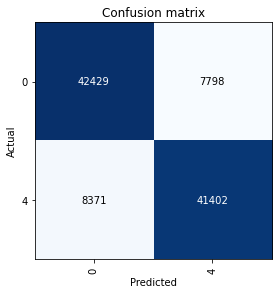

In [15]:
interp.plot_confusion_matrix()

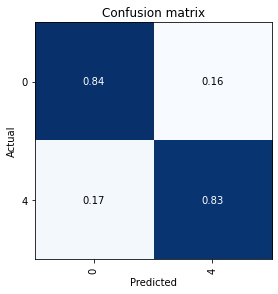

In [16]:
interp.plot_confusion_matrix(normalize='true')

In [17]:
losses = interp.top_losses()

In [18]:
len(losses[1])

100000

In [45]:
df_toplosses = interp.plot_top_losses(200)

,input,target,predicted,probability,loss
0,xxbos my hoodie has ears xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9991644620895386,7.087475299835205
1,xxbos i miss you sis xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9990839958190918,6.995491027832031
2,xxbos xxunk cool ! thank you thank you xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,4,0.9988101720809937,6.733932018280029
3,xxbos xxunk sorry about it xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9976257681846619,6.043074607849121
4,xxbos just woke up wondering why my itunes wo nt play songs and why my printer went spaz at four this morning .. xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.997430145740509,5.963930606842041
5,xxbos not going to school sick xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9960923790931702,5.544837474822998
6,xxbos last day of highschool tomorrow xxrep 4 ! so sad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9959447979927063,5.507761001586914
7,xxbos i wish i was in xxmaj california right now . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9941925406455994,5.148614406585693
8,xxbos i wish i was on an island . xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,4,0,0.9926954507827759,4.919257640838623
9,xxbos xxmaj good xxmaj bye xxmaj new xxmaj york ! xxup nyc was amazing ! xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,0,4,0.9924501180648804,4.886213779449463


In [46]:
top_200losses = df_losses[0:200]

In [47]:
top_200losses.merge(df_toplosses, on='loss')

TypeError: Can only merge Series or DataFrame objects, a <class 'NoneType'> was passed

In [48]:
valid = dls_clas.valid.items

In [49]:
valid = valid[['text', 'is_valid', 'target']]

In [50]:
valid.head()

,text,is_valid,target
1,"[xxbos, xxmaj, making, pasta, and, insalata, blu, with, mom]",True,4
2,"[xxbos, xxmaj, worst, ., xxmaj, day, ., xxmaj, ever, ., xxmaj, needing, some, legitimate, hug, action, ., xxmaj, show, starts, in, 30]",True,0
13,"[xxbos, @honnydipp, oh, no, today, is, not, a, good, day, ., xxmaj, aw, doll]",True,0
14,"[xxbos, grr, boys, annoy, the, shit, out, of, me, ,, why, ca, nt, i, just, hang, with, mah, girls, all, the, time]",True,4
31,"[xxbos, xxup, fuck, xxup, you, xxup, lord, xxup, of, xxup, the, xxup, flies, i, xxup, hate, xxup, you, -, bubbleant, :, xxup, o.o, xxmaj, you, hate, it, ?, !, i, loved, it, !, lol, xxmaj, but, i, read, it, a, long, …, http, :, /, /, tumblr.com, /, xbw1t3cwz]",True,4


In [51]:
valid[l] = valid.assign(prediction=pd.Series(preds[1]))

NameError: name 'l' is not defined

In [52]:
valid = valid.assign(prediction=pd.Series(preds[1]))

In [53]:
valid = valid.assign(probability_0=Series(preds[0]))

NameError: name 'Series' is not defined

In [54]:
valid = valid.assign(probability_0=Series(preds[0]))

NameError: name 'Series' is not defined

In [55]:
max(preds[0][0])

tensor(0.9736)

In [56]:
preds[0][0]

tensor([0.0264, 0.9736])

In [57]:
most_confused = interp.most_confused()

In [58]:
most_confused #actual, predicted, no of ocurences

[(4, 0, 2033), (0, 4, 1866)]

In [59]:
report = interp.print_classification_report()

              precision    recall  f1-score   support

           0       0.80      0.82      0.81     10156
           4       0.81      0.79      0.80      9844

    accuracy                           0.81     20000
   macro avg       0.81      0.80      0.80     20000
weighted avg       0.81      0.81      0.81     20000



In [147]:
?? ClassificationInterpretation.plot_top_losses